In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

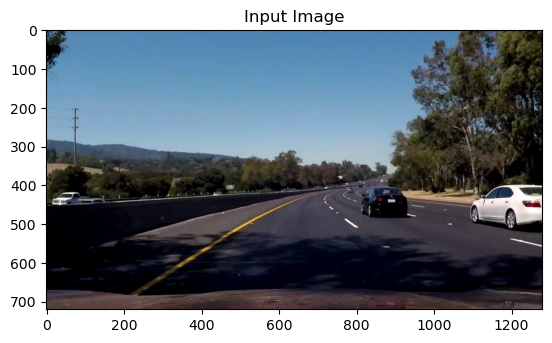

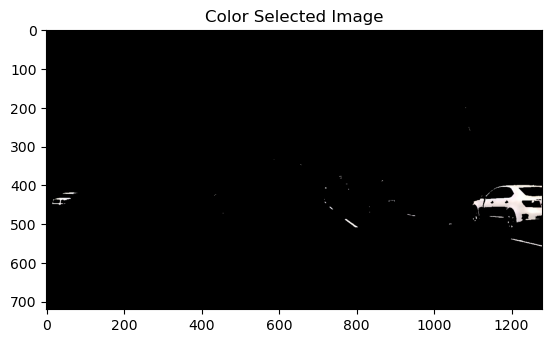

In [2]:
image = mpimg.imread(r"C:\Users\ILiYA\Desktop\Project\Media\Lane Line's Picture\project_video_frame_1048.jpg")
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(color_select)
plt.title("Color Selected Image")
plt.show()

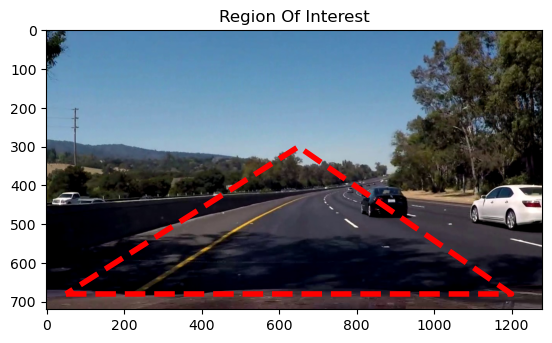

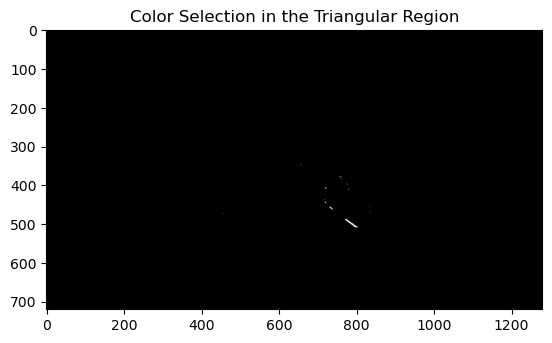

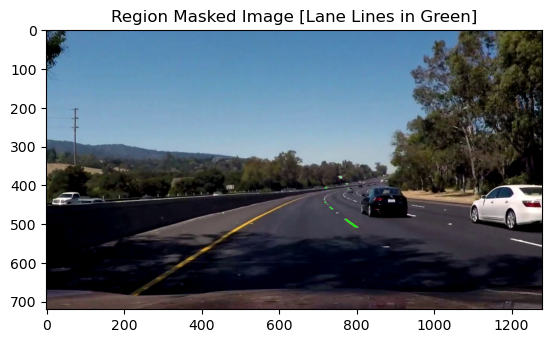

In [3]:
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]
left_bottom = [50, 680]
right_bottom = [1200, 680]
apex = [650, 300]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]

plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()
plt.imshow(color_select)
plt.title("Color Selection in the Triangular Region")
plt.show()
plt.imshow(line_image)
plt.title("Region Masked Image [Lane Lines in Green]")
plt.show()

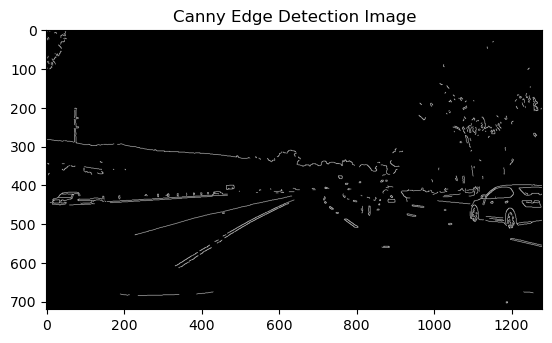

In [4]:
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection Image")
plt.show()

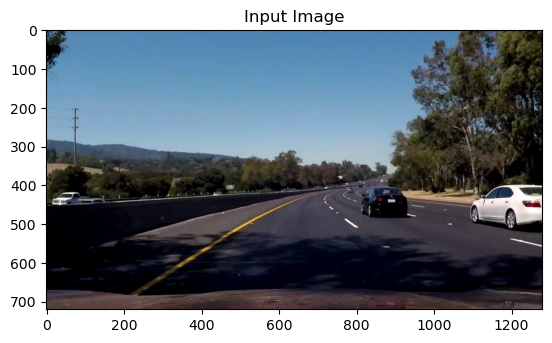

Text(0.5, 1.0, 'Colored Lane line [In RED] and Region of Interest [In Blue]')

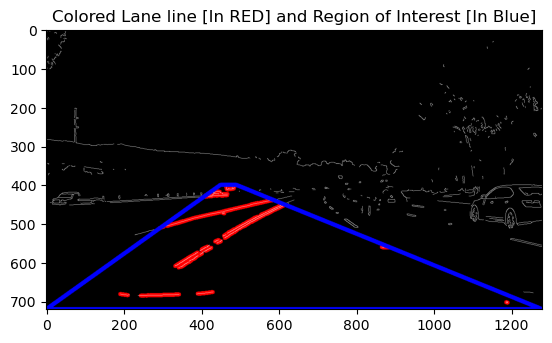

In [5]:
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

mask = np.zeros_like(edges)   
ignore_mask_color = 255   

imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 400), (490,400), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

rho = 1
theta = np.pi/180
threshold = 2    
min_line_length = 4
max_line_gap = 5 
line_image = np.copy(image)*0 

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

color_edges = np.dstack((edges, edges, edges)) 

lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")

In [6]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] 
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    for slope, intercept in [left_line, right_line]:
        rows, cols = image.shape[:2]
        y1= int(rows)
        y2= int(rows*0.6)
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = slope_lines(line_img,lines)
    return line_img

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [7]:
def lane_finding_pipeline(image):  
    gray_img = grayscale(image)
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    return output

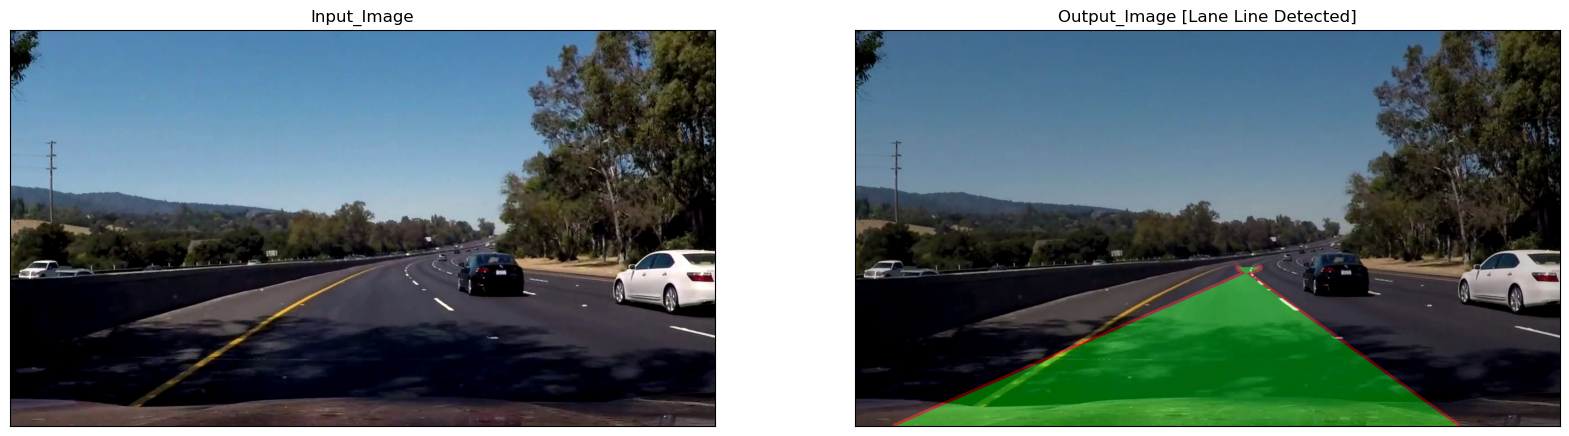

In [8]:
import os
fig = plt.figure(figsize=(20, 10))
image = mpimg.imread(r"C:\Users\ILiYA\Desktop\Project\Media\Lane Line's Picture\project_video_frame_1048.jpg")
ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
plt.imshow(image)
ax.set_title("Input_Image")
ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
plt.imshow(lane_finding_pipeline(image))
ax.set_title("Output_Image [Lane Line Detected]")
plt.show()

